In [1]:
import numpy as np
import csv
import scipy
from sklearn.model_selection import train_test_split



tlist = scipy.io.loadmat('Heston' + '_tlist.mat')
tlist = tlist['tlist'] # note that they are 2D array 
tlist = tlist.reshape((-1))
# Klist = scipy.io.loadmat('msft_Klist.mat')
Klist = scipy.io.loadmat('Heston' + '_Klist.mat')
Klist = Klist['Klist'] # note that they are 2D array
Klist = Klist.reshape((-1))
totalvarsurface = scipy.io.loadmat('HestonIVSgrid_NI91529.mat')
# totalvarsurface = scipy.io.loadmat('HestonIVSgrid_NI.mat')
# totalvarsurface = scipy.io.loadmat('HestonIVSgrid_NI87527.mat')

# totalvarsurface = totalvarsurface['totalvarsurface']
totalvarsurface = totalvarsurface['HestonIVS2D']
IVStrain, IVStest = train_test_split(totalvarsurface, test_size = 0.2, random_state = 42)

# Technique 1, initial noise scale

Choose $\sigma_1$ to be as large as the maximum Euclidean Distance between all pairs of training data points

## Without scale

In [2]:
IVStrain.shape

(73223, 8, 8)

In [3]:
# reshape 
A = IVStrain.reshape((IVStrain.shape[0], -1))
A.shape

(73223, 64)

In [117]:
# for large dataset 'HestonIVSgrid_NI91529.mat'
A1 = A[:20000]
A2 = A[20000:40000]
A3 = A[40000:60000]
A4 = A[60000:]
print(A1.shape[0] + A2.shape[0] + A3.shape[0] + A4.shape[0])

Asublist = [A1,A2,A3,A4]

73223


In [118]:
from sklearn.metrics.pairwise import euclidean_distances

sigma_1 = 1

for i in range(len(Asublist)):
    Aslice1 = Asublist[i]
    for j in range(i, len(Asublist)):
        Aslice2 = Asublist[j]
        pairwiseEDs = euclidean_distances(Aslice1, Aslice2)
        largestD = np.amax(pairwiseEDs)
        if largestD > sigma_1:
            sigma_1 = largestD
        print(i,j)

sigma_1

In [ ]:
# # all combinations
# datasize = A.shape[0]
# print('all combinations need to consider', datasize * (datasize-1) / 2)

# # combinations we have considered
# count = 0
# for i in range(len(Asublist)):
#     Aslice1 = Asublist[i]
#     for j in range(i, len(Asublist)):
#         Aslice2 = Asublist[j]
#         count += Aslice1.shape[0] * Aslice2.shape[0]

# count > datasize * (datasize-1) / 2


all combinations need to consider 2680767253.0


True

In [ ]:
# sigma_1

3.847108426799854

In [32]:
from sklearn.metrics.pairwise import euclidean_distances

pairwiseED = euclidean_distances(A,A)
sigma_1 = np.amax(pairwiseED)

In [9]:
sigma_1 

NameError: name 'sigma_1' is not defined

In [ ]:
# Another method, using sklearn.metrics.pairwise_distances
from sklearn.metrics import pairwise_distances
pairwiseED = pairwise_distances(A,A, metric='euclidean')
sigma_1 = np.amax(pairwiseED)

In [ ]:
sigma_1 # give the same answer

3.782251975058668

In [ ]:
sigma_1

3.847108426799854

In [287]:
# For 87257 dataset, 16 by 16 
# sigma_1 = 7.27022

In [4]:
# For 91829 dataset, 8 by 8 
sigma_1 = 3.84711

In [ ]:
# For original dataset, 8 by 8 
# sigma_1 = 3.783

# Technique 2, choose $\gamma = \frac{\sigma_{i-1}}{\sigma_i}$

Choose $\{\sigma_i\}^L_{i=1}$ as a geometric progression with common ratio $\gamma$ such that 
$\Phi(\sqrt{2D} ( \gamma - 1) + 3 \gamma) - \Phi(\sqrt{2D} (\gamma - 1 ) - 3 \gamma ) = C = 0.5$

The choice of $C$ is arbitray, motivated by practial experiments in image tasks.

Note that $\gamma = \frac{\sigma_{i-1}}{\sigma_i}$, so $\gamma > 1$. Recall that $\sigma_1 < \sigma_2 < ... < \sigma_L$

In [5]:
D = A.shape[-1]
D

64

In [6]:
C = 0.5

In [7]:
from scipy import optimize 
from scipy.stats import norm

def f(x):
    a = np.sqrt(2 * D) * (x - 1) 
    b = norm.cdf(a + 3*x) - norm.cdf(a - 3*x) - C
    return b

def fprime(x):
    a = np.sqrt(2 * D) * (x - 1) 
    b = norm.pdf(a+3*x) - norm.pdf(a-3*x)
    return b

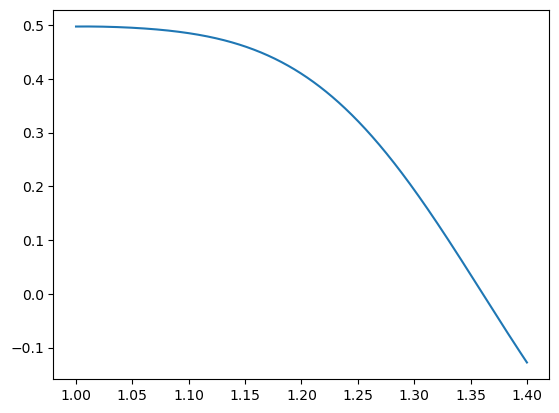

In [8]:
xpoints = np.linspace(1, 1.4, num = 1000)
ypoints = f(xpoints)
import matplotlib.pyplot as plt
plt.plot(xpoints, ypoints)
plt.show()

In [9]:
sol = optimize.root_scalar(f, fprime= fprime, bracket=[1,1.4])
sol.root

1.360849794092001

In [10]:
gamma = sol.root

In [11]:
f(gamma)

1.7141843500212417e-13

# Technique 3, $s_\theta(x, \sigma) = \frac{s_\theta(x)}{\sigma}$

Refer to the code in ncsnv2. Check the architecture.

# Technique 4, selecting $T$ and $\varepsilon$.

Choose $T$ as large as allowed by computing budget and then select $\varepsilon$ that makes the following maximally close to $1$.

$\frac{s_T^2}{\sigma_i^2}=\left(1-\frac{\epsilon}{\sigma_L^2}\right)^{2 T}\left(\gamma^2-\frac{2 \epsilon}{\sigma_L^2-\sigma_L^2\left(1-\frac{\epsilon}{\sigma_L^2}\right)^2}\right)+\frac{2 \epsilon}{\sigma_L^2-\sigma_L^2\left(1-\frac{\epsilon}{\sigma_L^2}\right)^2}$.

A typical reasonable computing budget is $T \cdot L$ being several thousands. 

Recall that $\sigma_L = \sigma_1 (1 / \gamma)^{L-1}$. So $ L = -\frac{\log(\sigma_L / \sigma_1 )}{\log (\gamma)} + 1$.

In [12]:
# sigma_1 = 3.84711

In [13]:
# sigma_1 = 3.783

In [14]:
sigma_1

3.84711

In [132]:
T = 1900 # the default choice is 100
sigma_L = 0.00001 # the default choice is 0.01
L = - np.log(sigma_L / sigma_1) / np.log(gamma) + 1
print('sigma_L:', '{:.20f}'.format(sigma_L))

sigma_L: 0.00001000000000000000


In [133]:
print('before taking ceil:',L)
L = np.ceil(L)
print('final integer L:', L)

# obtain the newgamma that is based on the L after taking ceiling
newgamma = np.power(sigma_1/ sigma_L, 1 / (L -1))
print('old gamma:', gamma)
print('newgamma:', newgamma)
print('T times L:', T* L)

before taking ceil: 42.73923169849942
final integer L: 43.0
old gamma: 1.360849794092001
newgamma: 1.3582490043113415
T times L: 81700.0


## Nelder-Mead instead of Grid search 

Fail to use the grid search, so I switch to Nelder-Mead method, using scipy.optimize.minimize. 

Based on numerical results, NM performs better than the graident-based methods. 

In [134]:
def g(x):
    """x for epsilon"""
    a = 2 *x / (sigma_L **2 - (sigma_L**2) * (1 - x / sigma_L **2)**2 )
    b = (1 - x / sigma_L**2) ** (2*T)

    # don't forget the -1 in the end, for optimizing the expression to maximally close to 1 
    return b * (newgamma**2 - a) + a - 1 

from scipy import optimize
# minimizer_object = optimize.minimize(g, 0.000001, method='Nelder-Mead', options={'xatol': 1e-8, 'disp': True}) # original

# minimizer_object = optimize.minimize(g, 0.0000000001, method='Nelder-Mead', options={'xatol': 1e-8, 'disp': True}) # ad hoc
# for small dataset replication for T =100, sigL6, 0.00000000000281250000
minimizer_object = optimize.minimize(g, 0.000000000001, method='Nelder-Mead', options={'xatol': 1e-8, 'disp': True}) # ad hoc

# options={'gtol': 1e-8, 'disp': True} 
# note that Nelder-Mead does not have gtol option
epsilon = minimizer_object.x
print('fun eval at minimizer:', minimizer_object.fun)

Optimization terminated successfully.
         Current function value: 0.001420
         Iterations: 7
         Function evaluations: 14
fun eval at minimizer: 0.0014201000439342248


In [135]:
print('T:', T)
print('sigma_L:', sigma_L)
print('e:', '{:.30f}'.format(epsilon[0]))

T: 1900
sigma_L: 1e-05
e: 0.000000000000200000000000001773


In [136]:
# from scipy.optimize import show_options
# show_options(solver="minimize", method='Nelder-Mead')
# show the options we can sue for Nelder-Mead method

## Plotting and old try

In [137]:
# xpoints = np.linspace(0.000008, 0.00002, num = 1000) 
# # 0.000008 and 0.00002 are some step_lr we have used before, 
# # note that 0.00002 is the default step_lr in ncsn v1
# ypoints = g(xpoints)
# import matplotlib.pyplot as plt
# plt.plot(xpoints, ypoints)
# plt.title("T={T}, sigma_L={sigma}".format(T=T, sigma=sigma_L))
# plt.show()


Note that we are looking for root!!!! So we want the y-axis is 0!! Don't be mistaken that we want to find y = 1.

In [138]:
# xpoints = np.linspace(0.000001, 0.00002, num = 1000) 
# # 0.000008 and 0.00002 are some step_lr we have used before, 
# # note that 0.00002 is the default step_lr in ncsn v1
# ypoints = g(xpoints)
# import matplotlib.pyplot as plt
# plt.plot(xpoints, ypoints)
# plt.title("T={T}, sigma_L={sigma}".format(T=T, sigma=sigma_L))
# plt.show()


In [139]:
# sol = optimize.root_scalar(g, x0 = 0.000001, x1 = 0.0000005) # , bracket=[1,1.4])
# root1 = sol.root
# root1

In [140]:
# g(root1)

In [141]:
# g(0.000000001)

Very sensitive to the initial guesses and it seems hard to come up with some possible initial guess. Let's use gridsearch..

In [142]:
# root2 = 0.0000025 
# root2 = 0.000008

# g(root2)

In [143]:
# Let's try bracket method...
# sol = optimize.root_scalar(g , bracket=[0.000001,0.000002]) 
# shit, they might not have different sign...
# maybe we should minimization method?


In [144]:
# from scipy import optimize
# ranges = ((0.000001, 0.00002))
# # ranges = (slice(1, 2, 100))

# # rranges = (slice(0.000001, 0.00002, 1000))

# resbrute = optimize.brute(g, ranges, Ns=1000)

# fail attempt at grid search

# Technique 5, Exponential moving average

Check the code in ncsnv2.